<a href="https://colab.research.google.com/github/GonkBunny/freeCodeCamp_BioInformatic/blob/main/BioActivity_ML_data_Part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Part 2-Computational Drug Discovery**
This follows the video : https://www.youtube.com/watch?v=jBlTQjcKuaY&t=1057s

## Installing conda and rdkit

In [2]:
! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
! chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh
! bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local
! conda install -c rdkit rdkit -y
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

--2021-08-10 22:52:15--  https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.130.3, 104.16.131.3, 2606:4700::6810:8303, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.130.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85055499 (81M) [application/x-sh]
Saving to: ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh’

Miniconda3-py37_4.8 100%[===================>]  81.12M   129MB/s    in 0.6s    

2021-08-10 22:52:16 (129 MB/s) - ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh’ saved [85055499/85055499]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: - done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - asn1crypto==1.3.0=py37_0
    - ca-certificates==2020.1.1=0
    - certifi==2019.11.28=py37_0
    - cffi==1.14.0=py37h2e261b9_0
    - chardet==3.0.4=py37_1003
    - conda-package-handling==1.6.0=py37h7b64

## Import libraries

In [3]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Calculate Lipinski descriptors
Christopher Lipinski, a scientist at Pfizer, came up with a set of rule-of-thumb for evaluating the **druglikeness** of compounds. Such druglikeness is based on the Absorption, Distribution, Metabolism and Excretion (ADME) that is also known as the pharmacokinetic profile. Lipinski analyzed all orally active FDA-approved drugs in the formulation of what is to be known as the **Rule-of-Five** or **Lipinski's Rule**.

The Lipinski's Rule stated the following:
* Molecular weight < 500 Dalton
* Octanol-water partition coefficient (LogP) < 5
* Hydrogen bond donors < 5
* Hydrogen bond acceptors < 10

##Reading the Dataset

In [5]:
data_path = '/content/drive/MyDrive/Colab Notebooks/data/bioactivity_preprocessed_data.csv'
df = pd.read_csv(data_path)

##Calculate descriptors

In [6]:
# Inspired by: https://codeocean.com/explore/capsules?query=tag:data-curation

def lipinski(smiles, verbose=False):
    '''
    Returns which of Lipinski's rules a molecule has failed, or an empty list
    
    Lipinski's rules are:
    Hydrogen bond donors <= 5
    Hydrogen bond acceptors <= 10
    Molecular weight < 500 daltons
    logP < 5
    '''
    moldata= []
    
    for elem in smiles:
        mol = Chem.MolFromSmiles(elem)       
        moldata.append(mol)
       
    baseData= np.arange(1,1)
    i=0  
    for mol in moldata:        
       
        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)
           
        row = np.array([desc_MolWt,
                        desc_MolLogP,
                        desc_NumHDonors,
                        desc_NumHAcceptors])   
    
        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1      
    
    columnNames=["MW","LogP","NumHDonors","NumHAcceptors"]   
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)
    
    return descriptors

In [7]:
df_lipinski = lipinski(df.canonical_smiles)

In [8]:
df_lipinski

,MW,LogP,NumHDonors,NumHAcceptors
0,369.368,3.51522,1.0,4.0
1,226.351,3.30451,0.0,5.0
2,334.400,3.26220,0.0,5.0
3,458.375,2.23320,8.0,11.0
4,237.052,2.22770,0.0,2.0
...,...,...,...,...
105,555.516,7.13050,1.0,4.0
106,182.222,3.20850,0.0,1.0
107,259.740,-1.01410,2.0,2.0
108,357.143,1.45040,1.0,5.0


Concat both Data Frames

In [9]:
df_combined = pd.concat([df, df_lipinski],axis=1)

In [10]:
df_combined

,molecule_chembl_id,canonical_smiles,bioactivity_class,standard_value,MW,LogP,NumHDonors,NumHAcceptors
0,CHEMBL480,Cc1c(OCC(F)(F)F)ccnc1C[S+]([O-])c1nc2ccccc2[nH]1,intermediate,390.0,369.368,3.51522,1.0,4.0
1,CHEMBL178459,Cc1c(-c2cnccn2)ssc1=S,intermediate,210.0,226.351,3.30451,0.0,5.0
2,CHEMBL3545157,O=c1sn(-c2cccc3ccccc23)c(=O)n1Cc1ccccc1,active,80.0,334.400,3.26220,0.0,5.0
3,CHEMBL297453,O=C(O[C@@H]1Cc2c(O)cc(O)cc2O[C@@H]1c1cc(O)c(O)...,inactive,1580.0,458.375,2.23320,8.0,11.0
4,CHEMBL4303595,O=C1C=Cc2cc(Br)ccc2C1=O,active,40.0,237.052,2.22770,0.0,2.0
...,...,...,...,...,...,...,...,...
105,CHEMBL376488,COc1nc2ccc(Br)cc2cc1[C@@H](c1ccccc1)[C@@](O)(C...,inactive,4360.0,555.516,7.13050,1.0,4.0
106,CHEMBL154580,C=CC(=O)c1ccc2ccccc2c1,inactive,1240.0,182.222,3.20850,0.0,1.0
107,CHEMBL354349,C[n+]1c2cc(N)ccc2cc2ccc(N)cc21.[Cl-],inactive,4980.0,259.740,-1.01410,2.0,2.0
108,CHEMBL1382627,Nc1ccc(S(=O)(=O)[N-]c2ncccn2)cc1.[Ag+],intermediate,750.0,357.143,1.45040,1.0,5.0


## **Convert IC50 to plC50**
To allow **IC50** data to be more uniformly distributed, we will convert **IC50** to the negative logarithmic scale which is essentially **-log10(IC50)**.

This custom function pIC50() will accept a DataFrame as input and will:
* Take the IC50 values from the ``standard_value`` column and converts it from nM to M by multiplying the value by 10$^{-9}$
* Take the molar value and apply -log10
* Delete the ``standard_value`` column and create a new ``pIC50`` column

In [11]:
import numpy as np

def pIC50(input):
    pIC50 = []

    for i in input['standard_value_norm']:
        molar = i*(10**-9) # Converts nM to M
        pIC50.append(-np.log10(molar))

    input['pIC50'] = pIC50
    x = input.drop('standard_value_norm', 1)
        
    return x

Point to note: Values greater than 100,000,000 will be fixed at 100,000,000 otherwise the negative logarithmic value will become negative

In [12]:
def norm_value(input):
    norm = []

    for i in input['standard_value']:
        if i > 100000000:
          i = 100000000
        norm.append(i)

    input['standard_value_norm'] = norm
    x = input.drop('standard_value', 1)
        
    return x

In [13]:
df_combined.standard_value.describe()

count     110.000000
mean     1358.272727
std      1388.661067
min        10.000000
25%       220.000000
50%       825.000000
75%      2065.000000
max      4980.000000
Name: standard_value, dtype: float64

In [14]:
df_norm = norm_value(df_combined)

In [15]:
df_norm.standard_value_norm.describe()

count     110.000000
mean     1358.272727
std      1388.661067
min        10.000000
25%       220.000000
50%       825.000000
75%      2065.000000
max      4980.000000
Name: standard_value_norm, dtype: float64

In [16]:
df_final = pIC50(df_norm)

In [17]:
df_final

,molecule_chembl_id,canonical_smiles,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL480,Cc1c(OCC(F)(F)F)ccnc1C[S+]([O-])c1nc2ccccc2[nH]1,intermediate,369.368,3.51522,1.0,4.0,6.408935
1,CHEMBL178459,Cc1c(-c2cnccn2)ssc1=S,intermediate,226.351,3.30451,0.0,5.0,6.677781
2,CHEMBL3545157,O=c1sn(-c2cccc3ccccc23)c(=O)n1Cc1ccccc1,active,334.400,3.26220,0.0,5.0,7.096910
3,CHEMBL297453,O=C(O[C@@H]1Cc2c(O)cc(O)cc2O[C@@H]1c1cc(O)c(O)...,inactive,458.375,2.23320,8.0,11.0,5.801343
4,CHEMBL4303595,O=C1C=Cc2cc(Br)ccc2C1=O,active,237.052,2.22770,0.0,2.0,7.397940
...,...,...,...,...,...,...,...,...
105,CHEMBL376488,COc1nc2ccc(Br)cc2cc1[C@@H](c1ccccc1)[C@@](O)(C...,inactive,555.516,7.13050,1.0,4.0,5.360514
106,CHEMBL154580,C=CC(=O)c1ccc2ccccc2c1,inactive,182.222,3.20850,0.0,1.0,5.906578
107,CHEMBL354349,C[n+]1c2cc(N)ccc2cc2ccc(N)cc21.[Cl-],inactive,259.740,-1.01410,2.0,2.0,5.302771
108,CHEMBL1382627,Nc1ccc(S(=O)(=O)[N-]c2ncccn2)cc1.[Ag+],intermediate,357.143,1.45040,1.0,5.0,6.124939


Removing the 'intermediate' bioactivity class 

In [18]:
df_2class= df_final[df_final.bioactivity_class != 'intermediate']
df_2class

,molecule_chembl_id,canonical_smiles,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
2,CHEMBL3545157,O=c1sn(-c2cccc3ccccc23)c(=O)n1Cc1ccccc1,active,334.400,3.26220,0.0,5.0,7.096910
3,CHEMBL297453,O=C(O[C@@H]1Cc2c(O)cc(O)cc2O[C@@H]1c1cc(O)c(O)...,inactive,458.375,2.23320,8.0,11.0,5.801343
4,CHEMBL4303595,O=C1C=Cc2cc(Br)ccc2C1=O,active,237.052,2.22770,0.0,2.0,7.397940
5,CHEMBL444186,CC(CN1CC(=O)NC(=O)C1)N1CC(=O)NC(=O)C1,inactive,268.273,-2.70830,2.0,6.0,5.496209
8,CHEMBL505670,O=[N+]([O-])c1ccc(Sc2cccc[n+]2[O-])c2nonc12,active,290.260,1.91560,0.0,7.0,7.000000
10,CHEMBL1271993,O=C1C(Cl)=C(N2CCOCC2)C(=O)N1c1ccc(Cl)c(Cl)c1,inactive,361.612,2.64920,0.0,4.0,5.343902
11,CHEMBL3665060,CN1CCN(C(=O)c2ccc(-c3ccc4c(C=O)c(O)ccc4c3)s2)CC1,inactive,380.469,3.47400,1.0,5.0,5.876148
16,CHEMBL286080,Oc1cc2c(cc1O)C(c1ccccc1)CNCC2,inactive,255.317,2.37540,3.0,3.0,5.552842
17,CHEMBL3963349,COC(=O)CC[C@H](NC(=O)[C@H](CC(=O)OC)NC(=O)OCc1...,active,668.672,0.00980,4.0,12.0,8.000000
18,CHEMBL480,Cc1c(OCC(F)(F)F)ccnc1C[S+]([O-])c1nc2ccccc2[nH]1,inactive,369.368,3.51522,1.0,4.0,5.795880


## Scatter Plot of IC50 and pIC50

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='ticks')
x = np.arange(len(df_final.pIC50))

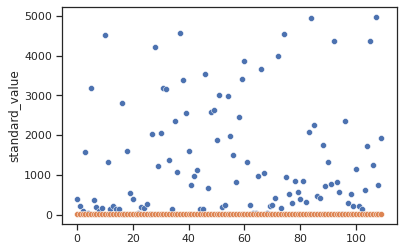

In [20]:
plt.figure()
sns.scatterplot(x=x,y=df_combined.standard_value)
sns.scatterplot(x=x,y=df_final.pIC50)
plt.show()

We can check that the values in IC50 are really disperse with high values.

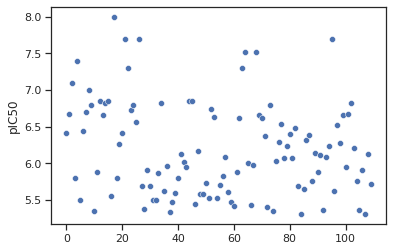

In [21]:
plt.figure()
sns.scatterplot(x=x,y=df_final.pIC50)
plt.show()

## Exploratory Data Analysis (Chemical Space Analysis) via Lipinski descriptors

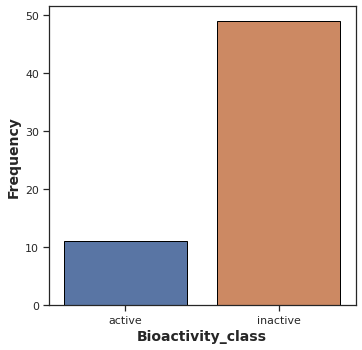

In [22]:
plt.figure(figsize=(5.5,5.5))

sns.countplot(x='bioactivity_class', data=df_2class, edgecolor='black')
plt.xlabel('Bioactivity_class', fontsize=14,fontweight='bold')
plt.ylabel('Frequency', fontsize=14,fontweight='bold')

plt.savefig('plot_bioactivity_class.pdf')

### Scatter plot of MW versus LogP

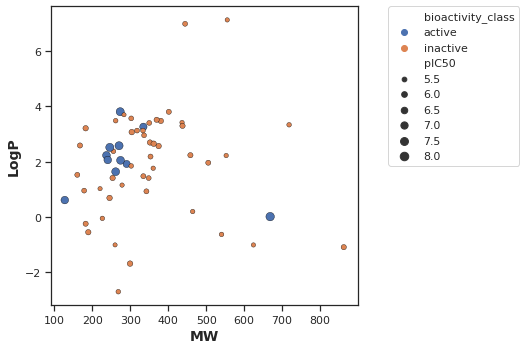

In [23]:
plt.figure(figsize=(5.5,5.5))

sns.scatterplot(x='MW',y='LogP',data=df_2class,hue='bioactivity_class',size='pIC50', edgecolor='black')

plt.xlabel('MW', fontsize=14,fontweight='bold')
plt.ylabel('LogP', fontsize=14,fontweight='bold')
plt.legend(bbox_to_anchor=(1.1,1), loc=2, borderaxespad=0)

plt.savefig('plot_MW_vs_LogP.pdf')

## Box Values

# pIC50 plot

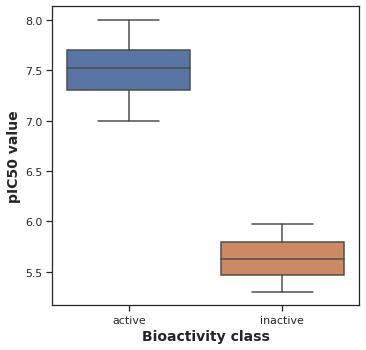

In [24]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'pIC50', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('pIC50 value', fontsize=14, fontweight='bold')

plt.savefig('plot_ic50.pdf')

### Mann-Whitney U Test

In [25]:
def mannwhitney(descriptor, verbose=False):
  # https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/
  from numpy.random import seed
  from numpy.random import randn
  from scipy.stats import mannwhitneyu

# seed the random number generator
  seed(1)

# actives and inactives
  selection = [descriptor, 'bioactivity_class']
  df = df_2class[selection]
  active = df[df.bioactivity_class == 'active']
  active = active[descriptor]

  selection = [descriptor, 'bioactivity_class']
  df = df_2class[selection]
  inactive = df[df.bioactivity_class == 'inactive']
  inactive = inactive[descriptor]

# compare samples
  stat, p = mannwhitneyu(active, inactive)
  #print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
  alpha = 0.05
  if p > alpha:
    interpretation = 'Same distribution (fail to reject H0)'
  else:
    interpretation = 'Different distribution (reject H0)'
  
  results = pd.DataFrame({'Descriptor':descriptor,
                          'Statistics':stat,
                          'p':p,
                          'alpha':alpha,
                          'Interpretation':interpretation}, index=[0])
  filename = 'mannwhitneyu_' + descriptor + '.csv'
  results.to_csv(filename)

  return results

In [26]:
mannwhitney('pIC50')

,Descriptor,Statistics,p,alpha,Interpretation
0,pIC50,0.0,1.376398e-07,0.05,Different distribution (reject H0)


### MW

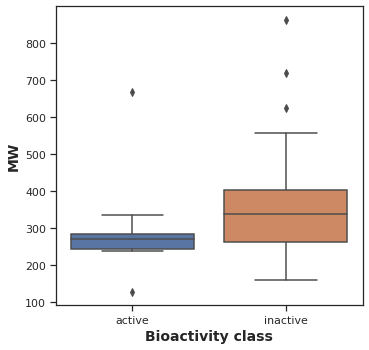

In [27]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'MW', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('MW', fontsize=14, fontweight='bold')

plt.savefig('plot_MW.pdf')

In [28]:
mannwhitney('MW')

,Descriptor,Statistics,p,alpha,Interpretation
0,MW,169.5,0.028655,0.05,Different distribution (reject H0)


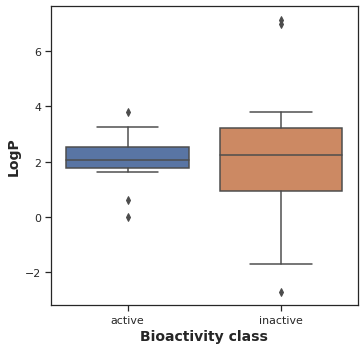

In [29]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'LogP', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')

plt.savefig('plot_LogP.pdf')

In [30]:
mannwhitney('LogP')

,Descriptor,Statistics,p,alpha,Interpretation
0,LogP,264.5,0.465744,0.05,Same distribution (fail to reject H0)


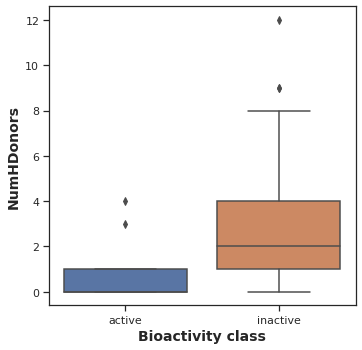

In [31]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'NumHDonors', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHDonors', fontsize=14, fontweight='bold')

plt.savefig('plot_NumHDonors.pdf')

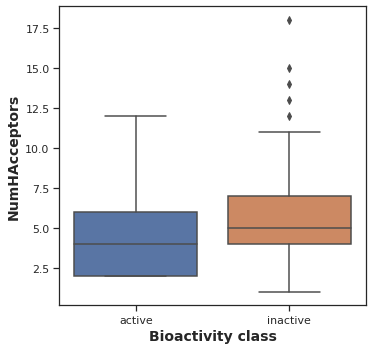

In [32]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'NumHAcceptors', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHAcceptors', fontsize=14, fontweight='bold')

plt.savefig('plot_NumHAcceptors.pdf')

In [33]:
mannwhitney('NumHAcceptors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHAcceptors,207.0,0.115778,0.05,Same distribution (fail to reject H0)


##### **Box Plots**

###### **pIC50 values**

Taking a look at pIC50 values, the **actives** and **inactives** displayed ***statistically significant difference***, which is to be expected since threshold values (``IC50 < 1,000 nM = Actives while IC50 > 10,000 nM = Inactives``, corresponding to ``pIC50 > 6 = Actives and pIC50 < 5 = Inactives``) were used to define actives and inactives.

###### **Lipinski's descriptors**

Of the 4 Lipinski's descriptors (MW, LogP, NumHDonors and NumHAcceptors), only LogP exhibited ***no difference*** between the **actives** and **inactives** while the other 3 descriptors (MW, NumHDonors and NumHAcceptors) shows ***statistically significant difference*** between **actives** and **inactives**.

In [34]:
! zip -r results.zip . -i *.csv *.pdf

Scanning files ..
  adding: plot_bioactivity_class.pdf (deflated 38%)
  adding: plot_NumHDonors.pdf (deflated 37%)
  adding: plot_NumHAcceptors.pdf (deflated 38%)
  adding: plot_ic50.pdf (deflated 37%)
  adding: mannwhitneyu_NumHAcceptors.csv (deflated 11%)
  adding: mannwhitneyu_pIC50.csv (deflated 10%)
  adding: plot_MW.pdf (deflated 37%)
  adding: mannwhitneyu_LogP.csv (deflated 7%)
  adding: plot_LogP.pdf (deflated 40%)
  adding: mannwhitneyu_MW.csv (deflated 8%)
  adding: plot_MW_vs_LogP.pdf (deflated 20%)
